You belong to the data team at a local research hospital. You've been tasked with developing a means to help doctors diagnose breast cancer. You've been given data about biopsied breast cells; where it is benign (not harmful) or malignant (cancerous).

- What features of a cell are the largest drivers of malignancy? Build a model that predicts whether a given biopsied breast cell is benign or malignant.
- What features drive your false positive rate for your model you derived above, what features drive your false negative rate? 
- How would a physician use your product?
- There is a non-zero cost in time and money to collect each feature about a given cell. How would you go about determining the most cost-effective method of detecting malignancy?

In addition to well-documented, extendable, and reusable code we are looking for a coherent data-story. This is a deliberately open-ended question that provides a chance to showcase your EDA, analysis, and presentation skills. The expectation is that you should spend no more than 4 hours on this task, and no more than 1 one preparing a presentation. 



In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix


In [230]:
df = pd.read_csv('breast-cancer-wisconsin.txt')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15855 entries, 0 to 15854
Data columns (total 12 columns):
Index                          15855 non-null int64
ID                             15855 non-null int64
Clump Thickness                15855 non-null int64
Uniformity of Cell Size        15827 non-null object
Uniformity of Cell Shape       15827 non-null object
Marginal Adhesion              15827 non-null object
Single Epithelial Cell Size    15827 non-null object
Bare Nuclei                    15827 non-null object
Bland Chromatin                15827 non-null object
Normal Nucleoli                15827 non-null object
Mitoses                        15827 non-null object
Class                          15827 non-null object
dtypes: int64(3), object(9)
memory usage: 1.5+ MB
None


,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


In [231]:
df['Class'].value_counts()

4          15164
2            456
40           151
?             23
No idea       17
#             11
20             5
Name: Class, dtype: int64

In [232]:
df = df[df['Class']!='No idea']
df = df[df['Class']!='?']
df = df[df['Class']!='#']
df = df[~df['Class'].isnull()]

df['Class'] = df['Class'].map({'4':0, '2':1, '40':0, '20':1})

In [233]:

df[df['Bare Nuclei']!='?']['Bare Nuclei'].value_counts()

10     5123
8      3006
3      2019
5      2016
1      1394
2      1027
6      1000
100      46
50       26
80       26
30       24
4        19
20       10
9         9
7         8
60        7
Name: Bare Nuclei, dtype: int64

In [234]:
# See of 'Bare Nuclei' what the distribution of '1' values look like
df[df['Class']==1]['Bare Nuclei'].value_counts()

1     385
2      21
3      14
?      14
5      10
10      7
4       6
8       2
20      1
7       1
Name: Bare Nuclei, dtype: int64

In [235]:
df[df['Bare Nuclei']=='?']

,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
157,157,1057067,1,1,1,1,1,?,1,1,1,1
1144,1144,1238464,1,1,1,1,1,?,2,1,1,1
1799,1799,169356,3,1,1,1,2,?,3,1,1,1
2398,2398,563649,8,8,8,1,2,?,6,10,1,0
3727,3727,61634,5,4,3,1,2,?,2,3,1,1
5059,5059,1096800,6,6,6,9,6,?,7,8,1,1
6563,6563,1241232,3,1,4,1,2,?,3,1,1,1
6752,6752,1193683,1,1,2,1,3,?,1,1,1,1
7122,7122,432809,3,1,3,1,2,?,2,1,1,1
7539,7539,1184840,1,1,3,1,2,?,2,1,1,1


### Below is a guess for what to replace it with, since 'Bare Nuclei' seems to contain a lot of the elusive '1' states, so I replaced it with the most popular value of 1 for the subclass of 1 states

This choice is likely to have a big effect since there are so few '1' categories.  Do feel free to revisit this choice as you are optimizing the model

In [236]:
df['Bare Nuclei'] = df['Bare Nuclei'].replace('?', 1)

In [237]:
df['Class'].value_counts()

0    15315
1      461
Name: Class, dtype: int64

In [238]:
461/(15315+461)

# 3% imbalanced data!

0.02922160243407708

In [240]:
df['ID'].value_counts()

1142706     999
378275      998
1107684     998
1226612     998
1076352     997
1200892     997
1112209     997
1106829     996
1169049     996
691628      995
1241035     995
601265      994
1110524     994
1198641     994
1111249     993
11690490     16
12410350     13
11112490     13
6916280      13
11076840     11
12266120     10
6012650       9
12008920      9
3782750       9
11427060      8
11105240      8
11986410      8
10763520      8
11068290      7
11122090      7
           ... 
1222936       1
1183983       1
1368273       1
1239232       1
1296572       1
1183911       1
1253505       1
1167471       1
1214556       1
1167439       1
1227210       1
1149548       1
474162        1
1176187       1
1268766       1
846832        1
1168359       1
1315807       1
1303489       1
1156017       1
684955        1
1219406       1
324427        1
1211202       1
1059552       1
1200847       1
1319609       1
709287        1
412300        1
1173509       1
Name: ID, Length: 665, d

In [244]:
### According to docs, all values should be integers from 1 to 10

for column in df.columns:
    df[column] = df[column].astype(int)
    for value in df[column].unique():
        if value > 10:
             df[column].replace(value,value/10, inplace=True)
            

In [255]:
#df_unique = df.groupby('ID').mean()
#df = df.drop(['Index', 'ID'], axis=1) #head()

In [260]:
df = df.groupby('ID').agg(lambda x:x.value_counts().index[0])


In [263]:
df = df.drop(['Index'], axis=1) #head()

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 661 entries, 6163.4 to 1345435.2
Data columns (total 10 columns):
Clump Thickness                661 non-null int64
Uniformity of Cell Size        661 non-null int64
Uniformity of Cell Shape       661 non-null int64
Marginal Adhesion              661 non-null int64
Single Epithelial Cell Size    661 non-null int64
Bare Nuclei                    661 non-null int64
Bland Chromatin                661 non-null int64
Normal Nucleoli                661 non-null int64
Mitoses                        661 non-null int64
Class                          661 non-null int64
dtypes: int64(10)
memory usage: 56.8 KB


In [265]:
df.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
ID,,,,,,,,,,
6163.4,5,4,3,1,2,1,2,3,1,1
6337.5,9,1,2,6,4,10,7,7,2,0
7638.9,10,4,7,2,2,8,6,1,1,0
9571.9,6,10,10,10,8,10,7,10,7,0
12805.9,1,1,1,1,2,5,5,1,1,1


In [270]:
df_unique['Class'].value_counts()

1.000000    411
0.000000    246
0.500000      3
0.002012      1
Name: Class, dtype: int64

In [271]:
df['Clump Thickness'].unique()

array([ 5,  9, 10,  6,  1,  7,  8,  4,  3,  2])

In [273]:
for column in df.columns:
    print(column, df[column].value_counts())

Clump Thickness 1     128
5     122
3     102
10     75
4      68
2      48
8      47
6      32
7      27
9      12
Name: Clump Thickness, dtype: int64
Uniformity of Cell Size 1     338
10     69
3      52
2      45
4      41
5      31
8      30
6      30
7      19
9       6
Name: Uniformity of Cell Size, dtype: int64
Uniformity of Cell Shape 1     307
10     59
3      58
2      57
4      45
5      36
6      33
7      32
8      27
9       7
Name: Uniformity of Cell Shape, dtype: int64
Marginal Adhesion 1     363
3      61
10     59
2      57
4      33
8      24
6      24
5      21
7      14
9       5
Name: Marginal Adhesion, dtype: int64
Single Epithelial Cell Size 2     352
3      78
4      48
6      42
1      39
5      38
10     29
8      21
7      12
9       2
Name: Single Epithelial Cell Size, dtype: int64
Bare Nuclei 1     372
10    137
5      30
3      30
2      30
8      23
4      18
9       8
7       8
6       5
Name: Bare Nuclei, dtype: int64
Bland Chromatin 3     157
2     15

# Okay let's model this thing

In [274]:
y = df['Class']
X = df.drop('Class', axis=1)

In [275]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2)

In [276]:
d_train = xgb.DMatrix(data=X_train, label=y_train)
d_test = xgb.DMatrix(data=X_test)#, label=y_test)

In [277]:
params = {'max_depth': 6, 
          'objective': 'binary:logistic',
          'eta': 0.1,
   #       'n_estimators':1000,
          'booster': 'gbtree',
          'eval_metric': 'logloss'}

In [312]:
t = time.time()

num_rounds = 100
xgb_model = xgb.train(params, d_train, num_rounds)

print('Elapsed Time: ', time.time()-t)

[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[19:39:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_

In [316]:
y_pred_xgb = xgb_model.predict(d_test)
y_pred_xgb_proba = y_pred_xgb
y_pred_xgb = y_pred_xgb.round()

y_pred_xgb

array([0.00642404, 0.99901474, 0.9993692 , 0.00865288, 0.00181596,
       0.999132  , 0.00257919, 0.9990159 , 0.99887055, 0.9993692 ,
       0.00185047, 0.9993692 , 0.9984622 , 0.03925332, 0.9990088 ,
       0.05042991, 0.0290806 , 0.999132  , 0.00383138, 0.00407799,
       0.999132  , 0.9993692 , 0.00570455, 0.999132  , 0.9579491 ,
       0.99122787, 0.9989673 , 0.9982449 , 0.9993692 , 0.9991265 ,
       0.9988943 , 0.00290808, 0.9919031 , 0.9993692 , 0.01070147,
       0.9980876 , 0.999132  , 0.00442079, 0.44395673, 0.9992495 ,
       0.999132  , 0.9992495 , 0.00416026, 0.999132  , 0.00391351,
       0.9933408 , 0.01799759, 0.9990088 , 0.9990159 , 0.9993692 ,
       0.99690115, 0.9889931 , 0.00685894, 0.9992495 , 0.9983011 ,
       0.9993692 , 0.9989673 , 0.00299572, 0.00279058, 0.9992495 ,
       0.00206949, 0.00699844, 0.37209743, 0.01985542, 0.00314174,
       0.00914834, 0.99690115, 0.9992495 , 0.999132  , 0.9975278 ,
       0.9621581 , 0.9992495 , 0.00782442, 0.00667052, 0.00338

In [282]:

accuracy = accuracy_score(y_test, y_pred_xgb), 
f1 = f1_score(y_test, y_pred_xgb), 
roc_auc = roc_auc_score(y_test, y_pred_xgb)

accuracy, f1, roc_auc

((0.9624060150375939,), (0.9696969696969696,), 0.9659863945578231)

In [283]:
confusion_matrix(y_test, y_pred_xgb)

array([[48,  1],
       [ 4, 80]])

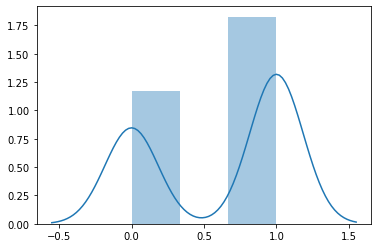

In [284]:
sns.distplot(y_pred_xgb.round())

# For comparison consider RandomForest, Logistic Regression, and LDA

In [324]:
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)
y_pred_logistic = logistic_model.predict(X_test)
y_pred_proba_logistic = logistic_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred_logistic), 
f1 = f1_score(y_test, y_pred_logistic), 
roc_auc = roc_auc_score(y_test, y_pred_logistic)

accuracy, f1, roc_auc

((0.9548872180451128,), (0.9642857142857143,), 0.9515306122448981)

In [286]:
confusion_matrix(y_test, y_pred_logistic)

array([[46,  3],
       [ 3, 81]])

In [321]:
from sklearn.ensemble import RandomForestClassifier

randomforest_model = RandomForestClassifier(n_estimators=500)

randomforest_model.fit(X_train, y_train)
y_pred_RF = randomforest_model.predict(X_test)
y_pred_proba_RF = randomforest_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred_RF), 
f1 = f1_score(y_test, y_pred_RF), 
roc_auc = roc_auc_score(y_test, y_pred_RF)

accuracy, f1, roc_auc

((0.9624060150375939,), (0.9696969696969696,), 0.9659863945578231)

In [288]:
confusion_matrix(y_test, y_pred_RF)

array([[48,  1],
       [ 4, 80]])

In [308]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

LDA_model = LinearDiscriminantAnalysis()


LDA_model.fit(X_train, y_train)
y_pred_LDA = LDA_model.predict(X_test)
y_pred_proba_LDA = LDA_model.predict_proba(X_test)


accuracy = accuracy_score(y_test, y_pred_LDA), 
f1 = f1_score(y_test, y_pred_LDA), 
roc_auc = roc_auc_score(y_test, y_pred_LDA)

accuracy, f1, roc_auc

((0.9473684210526315,), (0.9585798816568047,), 0.941326530612245)

In [290]:
confusion_matrix(y_test, y_pred_LDA)

array([[45,  4],
       [ 3, 81]])

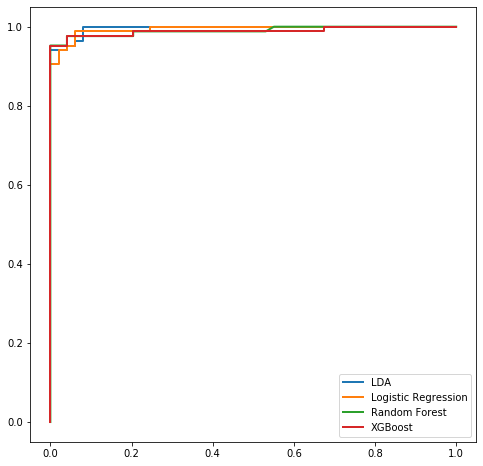

In [332]:
# Modified from code from fellow Insight...fellow Alexandro Ramirez
from sklearn.metrics import roc_curve, auc, roc_auc_score

#lw=2
plt.figure(figsize = (8, 8))

name='LDA'
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_LDA[:,1], pos_label =1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,lw=lw,label= name)

name='Logistic Regression'
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_logistic[:,1], pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,lw=lw,label= name)

name='Random Forest'
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_RF[:,1], pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,lw=lw,label= name )

name='XGBoost'
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgb_proba, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr,lw=lw,label= name )
plt.legend()